## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

In [8]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from tqdm import tqdm_notebook as tqdm
from IPython.display import Image

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

You should store the unzipped folder in Drive for use in this Colab notebook.

In [9]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('gdrive/MyDrive/Colab Notebooks/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [11]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

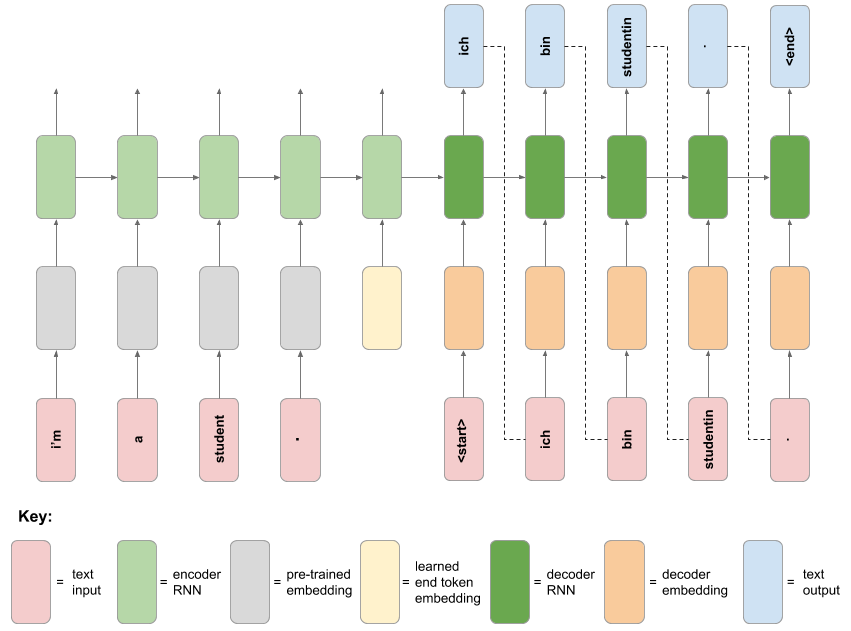

In [12]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [13]:
sentences = [i.split('\t')[:2] for i in data_examples]

In [14]:
# Split the data into English and German sentences
en_sentences = [preprocess_sentence(i[0]) for i in sentences]
de_sentences = ["<start> "+preprocess_sentence(i[1])+" <end>" for i in sentences]

In [15]:
# Tokenize all German sentences
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(de_sentences)
de_tokens = tokenizer.texts_to_sequences(de_sentences)

In [16]:
# Print some random examples of the data as it is so far
random_idx = tf.cast(tf.random.uniform(minval=0,maxval=len(sentences), shape=[5]), tf.int64)
for idx in random_idx:
    print("Original English:", en_sentences[idx.numpy()])
    print("Original German:", de_sentences[idx.numpy()])
    print("Tokenized German:", de_tokens[idx.numpy()])
    print()

Original English: everyone's asleep .
Original German: <start> alle schlafen . <end>
Tokenized German: [1, 78, 260, 3, 2]

Original English: raise your hand .
Original German: <start> heben sie ihre hand . <end>
Tokenized German: [1, 1567, 8, 202, 651, 3, 2]

Original English: i don't dream .
Original German: <start> ich traeume nicht . <end>
Tokenized German: [1, 4, 940, 12, 3, 2]

Original English: i need to focus .
Original German: <start> ich muss mich konzentrieren . <end>
Tokenized German: [1, 4, 85, 22, 4271, 3, 2]

Original English: be brave .
Original German: <start> seid tapfer ! <end>
Tokenized German: [1, 73, 881, 9, 2]



In [17]:
# Pad German sentences with zeros
de_padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(de_tokens, padding='post')
print(de_padded_tokens[0])

[  1 405   9   2   0   0   0   0   0   0   0   0   0   0]


## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [18]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [19]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [20]:
# Split training and validation data
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(np.array(en_sentences), de_padded_tokens, test_size=0.2)
print("train shape: {}".format(X.shape))
print("train label shape: {}".format(y.shape))
print("test shape: {}".format(X_test.shape))
print("test label shape: {}".format(y_test.shape))

train shape: (16000,)
train label shape: (16000, 14)
test shape: (4000,)
test label shape: (4000, 14)


In [21]:
# Create training and validation sets as tf.data.Dataset objects
train_set = tf.data.Dataset.from_tensor_slices((X, y))
valid_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
# Split English sentences at spaces
def string_split(x, y):
    return tf.strings.split(x), y

train_set = train_set.map(string_split)
valid_set = valid_set.map(string_split)

In [23]:
# Embed each English sentence using the pretrained word embeddings installed above
def embed_English(x, y):
    return embedding_layer(x), y

train_set = train_set.map(embed_English)
valid_set = valid_set.map(embed_English)

In [24]:
# Filter out English sentences with more than 13 words
def filter_long_sentences(x, y):
    return len(x) < 13

train_set = train_set.filter(filter_long_sentences)
valid_set = valid_set.filter(filter_long_sentences)

In [25]:
# Pad word embeddings to a fixed length of 13
def pad_word_embeddings(x, y=None):
    paddings=[[13-tf.shape(x)[0],0],[0,0]]
    return tf.pad(x, paddings), y

train_set = train_set.map(pad_word_embeddings)
valid_set = valid_set.map(pad_word_embeddings)

In [26]:
# Batch both training and validation Datasets with a batch size of 16
train_set = train_set.batch(16)
valid_set = valid_set.batch(16)

In [27]:
print(train_set.element_spec)
print(valid_set.element_spec)

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [28]:
# Inspect an English input
print(next(iter(train_set.take(1)))[0].shape)
# A batch has 16 examples, 13 -padded- vocables and 128 embedding dimensions

(16, 13, 128)


In [29]:
# Inspect an German output
print(next(iter(train_set.take(1)))[1].shape)
# A batch has 16 examples, and 31 -padded- tokens

(16, 14)


In [30]:
# Display an example
print(next(iter(train_set.take(1)))[1])


tf.Tensor(
[[   1    5   68  443    3    2    0    0    0    0    0    0    0    0]
 [   1    8  114  700   41    3    2    0    0    0    0    0    0    0]
 [   1 3967   13   62    7    2    0    0    0    0    0    0    0    0]
 [   1    5   16   34  181  182    3    2    0    0    0    0    0    0]
 [   1   23    8  413    7    2    0    0    0    0    0    0    0    0]
 [   1    8  311  198 2052   36    3    2    0    0    0    0    0    0]
 [   1    5   66  292    3    2    0    0    0    0    0    0    0    0]
 [   1 5440    6   37 1445    3    2    0    0    0    0    0    0    0]
 [   1    4   24  337    3    2    0    0    0    0    0    0    0    0]
 [   1    5  277   11    3    2    0    0    0    0    0    0    0    0]
 [   1    4   15 5716    3    2    0    0    0    0    0    0    0    0]
 [   1   11   97   49   41    3    2    0    0    0    0    0    0    0]
 [   1   14  872   20  309    3    2    0    0    0    0    0    0    0]
 [   1   13   32 2087    3    2    0    

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

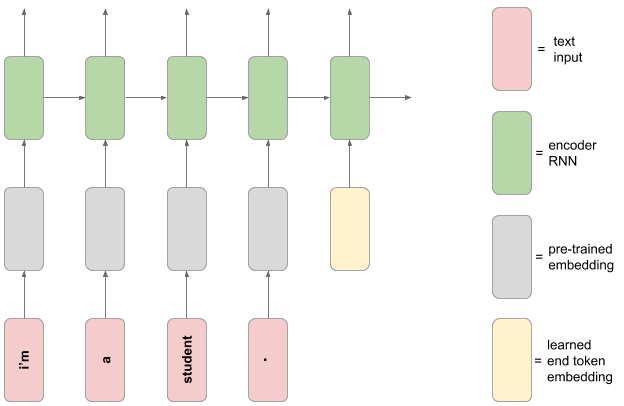

In [31]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [32]:
class AddEndToken(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AddEndToken, self).__init__(**kwargs)
        self.end_token = tf.Variable(initial_value=tf.random.normal(shape=(1, 128), dtype=tf.float32), trainable=True)

    def call(self, inputs):
        """Adds a trainable end token at the very end of each sentence"""

        x = tf.tile(self.end_token,[tf.shape(inputs)[0],1])
        x = tf.expand_dims(x, axis=1)
        return tf.keras.layers.Concatenate(axis=1)([inputs, x])

In [33]:
print("Before <end> token addition:", (next(iter(train_set.take(1)))[0].shape))
print("After <end> token addition:", AddEndToken()(next(iter(train_set.take(1)))[0]).shape)
# A batch has 16 examples, 14 -padded- vocables (1 more than bofore, due to the 
# trainable end token) and 128 embedding dimensions

Before <end> token addition: (16, 13, 128)
After <end> token addition: (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [34]:
inputs = tf.keras.layers.Input(batch_shape=(None, 13, 128))
x = AddEndToken()(inputs)
x = tf.keras.layers.Masking(mask_value=0.)(x)
x, hidden, cell = tf.keras.layers.LSTM(512, return_state=True)(x)

encoder = tf.keras.models.Model(inputs, [hidden, cell])

In [35]:
encoder_test = encoder(next(iter(train_set.take(1)))[0])
print("Hidden state shape: {}".format(encoder_test[0].shape))
print("Cell state shape: {}".format(encoder_test[1].shape))

Hidden state shape: (16, 512)
Cell state shape: (16, 512)


In [36]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 128)]         0         
_________________________________________________________________
add_end_token_1 (AddEndToken (None, 14, 128)           128       
_________________________________________________________________
masking (Masking)            (None, 14, 128)           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

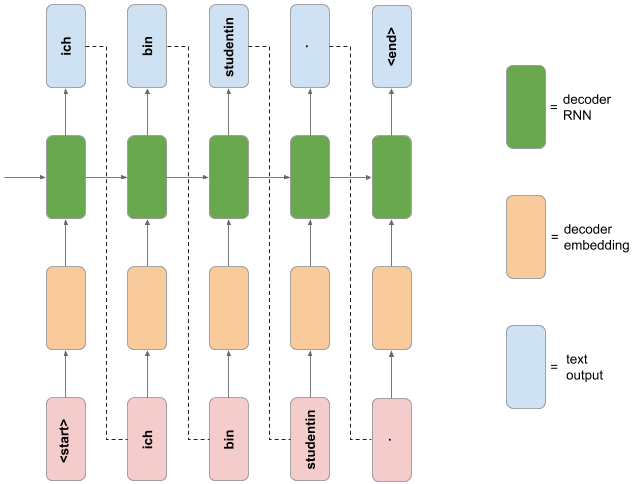

In [37]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [45]:
class decoder(tf.keras.Model):
    def __init__(self, **kwargs):
        super(decoder, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(len(tokenizer.word_index)+1)

    def call(self, inputs, hidden_state=None, cell_state=None):
        x = self.embedding(inputs)
        if hidden_state is not None and cell_state is not None:
            x, hidden, cell = self.lstm(x, initial_state=[hidden_state, cell_state])
        else:
            x, hidden, cell = self.lstm(x)
        x = self.dense(x)
        #x = tf.keras.activations.softmax(x)
        return x, hidden, cell

In [46]:
dec = decoder()

example = next(iter(train_set.take(1)))
hidden, cell = encoder(example[0])
decoder_test = dec(example[1], hidden, cell)
print("Output shape: {}".format(decoder_test[0].shape))
print("Hidden state shape: {}".format(decoder_test[1].shape))
print("Cell state shape: {}".format(decoder_test[2].shape))

Output shape: (16, 14, 5744)
Hidden state shape: (16, 512)
Cell state shape: (16, 512)


In [47]:
dec.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  735232    
_________________________________________________________________
lstm_2 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense_1 (Dense)              multiple                  2946672   
Total params: 4,994,672
Trainable params: 4,994,672
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [48]:
# Take a batch of German data, and returns a tuple with decoder inputs and outputs
import json
tokenizer_config = tokenizer.get_config()
word_indexs = json.loads(tokenizer_config['word_index'])
token2words = {v:k for k,v in word_indexs.items()}

def decoderIO(de_batch):
    de_in = tf.where(de_batch==2, 0, de_batch)
    de_out = de_batch[:,1:]
    zeros = tf.zeros((de_batch.shape[0], 1), dtype=tf.int32)
    de_out = tf.concat((de_out, zeros), axis=1)
    return de_in, de_out

test_decoderio = decoderIO(next(iter(train_set.take(1)))[1])

print(test_decoderio[0].shape)
print(test_decoderio[1].shape)

(16, 14)
(16, 14)


In [52]:
@tf.function
def grad(encoder, decoder, en_in, de_in, de_out, loss):

    with tf.GradientTape() as tape:
        hidden, cell = encoder(en_in)
        y, _, _ = decoder(de_in, hidden, cell)
        loss = loss(de_out, y)

        train_vars = encoder.trainable_variables + decoder.trainable_variables

    return loss, tape.gradient(loss, train_vars)

In [53]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [54]:
n_epochs = 25
n_valid = 25
enc = encoder
dec = decoder()

In [57]:
train_loss_history = []
val_loss_history = []

for epoch in range(n_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    val_epoch_loss_avg = tf.keras.metrics.Mean()

    #Training Loop
    for X, y in tqdm(train_set):
        #Optmize the model
        inp, out = decoderIO(y)
        loss_value, grads = grad(enc, dec, X, inp, out, loss)

        train_vars = enc.trainable_variables + dec.trainable_variables
        optimizer.apply_gradients(zip(grads, train_vars))

        #Compute current loss
        epoch_loss_avg(loss_value)

    for en, de in valid_set.take(n_valid):
        inp, out = decoderIO(de)
        loss_val, _ = grad(enc, dec, en, inp, out, loss)
        val_epoch_loss_avg(loss_val)
    
    train_loss_history.append(epoch_loss_avg.result())
    val_loss_history.append(val_epoch_loss_avg.result())

    print(" Epoch :{:03d}: Loss: {:.3f} : Val_Loss: {:.3f}".format(
        epoch, epoch_loss_avg.result().numpy(), val_epoch_loss_avg.result().numpy())
    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



 Epoch :000: Loss: 1.595 : Val_Loss: 1.528



 Epoch :001: Loss: 1.490 : Val_Loss: 1.436



 Epoch :002: Loss: 1.407 : Val_Loss: 1.373



 Epoch :003: Loss: 1.326 : Val_Loss: 1.302



 Epoch :004: Loss: 1.249 : Val_Loss: 1.237



 Epoch :005: Loss: 1.184 : Val_Loss: 1.194



 Epoch :006: Loss: 1.129 : Val_Loss: 1.155



 Epoch :007: Loss: 1.079 : Val_Loss: 1.117



 Epoch :008: Loss: 1.033 : Val_Loss: 1.088



 Epoch :009: Loss: 0.991 : Val_Loss: 1.065



 Epoch :010: Loss: 0.952 : Val_Loss: 1.042



 Epoch :011: Loss: 0.915 : Val_Loss: 1.021



 Epoch :012: Loss: 0.880 : Val_Loss: 1.003



 Epoch :013: Loss: 0.847 : Val_Loss: 0.987



 Epoch :014: Loss: 0.816 : Val_Loss: 0.977



 Epoch :015: Loss: 0.785 : Val_Loss: 0.964



 Epoch :016: Loss: 0.757 : Val_Loss: 0.954



 Epoch :017: Loss: 0.730 : Val_Loss: 0.950



 Epoch :018: Loss: 0.704 : Val_Loss: 0.948



 Epoch :019: Loss: 0.680 : Val_Loss: 0.936



 Epoch :020: Loss: 0.655 : Val_Loss: 0.928



 Epoch :021: Loss: 0.632 : Val_Loss: 0.918



 Epoch :022: Loss: 0.608 : Val_Loss: 0.912



 Epoch :023: Loss: 0.587 : Val_Loss: 0.908



 Epoch :024: Loss: 0.566 : Val_Loss: 0.899


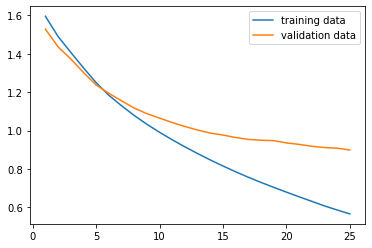

In [59]:
import matplotlib.pyplot as plt
plt.plot(range(1,26), train_loss_history, label="training data")
plt.plot(range(1,26), val_loss_history, label="validation data")
plt.legend()
plt.show()

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [60]:
#@tf.function
def translate(en_original, encoder, decoder, max_length=5):

    #Split the sentence at spaces, and embed it using the same
    #pretrained word embeddings
    preprocessed_en = embedding_layer(np.array(en_original.split(" ")))
    preprocessed_en = pad_word_embeddings(preprocessed_en)[0]
    preprocessed_en = tf.expand_dims(preprocessed_en, axis=0)

    #Pass the sentence through encoder and decoder
    hidden, cell = encoder(preprocessed_en)
    de_translation = []
    z = 1
    while z != 2 and len(de_translation) < max_length:
        y, hidden, cell = decoder(np.expand_dims(z, axis=[0,1]), hidden, cell)
        z = np.argmax(np.squeeze(y))
        de_translation.append(token2words[z+1])

    return en_original, " ".join(de_translation), y

In [61]:
random_sentences = iter(valid_set.shuffle(1000).take(5))

In [62]:
# Retrieve five random sentences for testing translation
test_indexes = np.random.choice(range(1,1001), 5)
test_sentences = [sentences[i][0] for i in test_indexes]
test_sentences

['No way!', 'Stop that!', 'Say "aah."', 'Fix this.', 'Be a man.']

In [63]:
# Translate those sentences!
for sent in test_sentences:
    print(translate(sent, enc, dec)[:2])

('No way!', 'einfach es .')
('Stop that!', 'ihn es .')
('Say "aah."', 'hol es .')
('Fix this.', 'ihn sie .')
('Be a man.', 'habe war was besser es')
